***Notebook Author:*** Trenton McKinney
Course: DataCamp: Fraud Detection in Python
This notebook was created as a reproducible reference.

This exercise uses parts of McKinney's notebook. Some comments and questions have been added by RK. 

<h4> 3.4 Fraud detection with labelled data </h4> 

In this exercise, we use credit card data. As there are very few fradulent occurences in the data, we try SMOTE resampling. We then try to detect fradulent transactions using statistical threshold. We compare Logistic regression with the original data and with resampled data. 

Then, using a new set of credit card data, we compare the performance of random forest and logistic regression, changing model options in both methods. 

In [2]:
pip install imblearn

   ---------------------------------------- 0.0/257.7 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/257.7 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------  256.0/257.7 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 257.7/257.7 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler


In [3]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [4]:
data = Path.cwd() / 'data' 

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'



In [5]:
df = pd.read_csv(cc3_file)

Lets first print df.info() and the first rows of the dataframe to see what data we have. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [8]:
# first rows of the dataframe here

df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


The last column Class defines whether the transaction is fraud (1) or no fraud (0). Count the occurrences of fraud and no fraud and print them. Then, compute and print the ratio of fraud cases. 

In [ ]:
# Count the occurrences of fraud and no fraud and print them
occ = 


In [ ]:
# Print the ratio of fraud cases
ratio_cases = ..


Q: What can you say about the ratio of fraudulent cases? What could you do to improve the efficiency of fraud detection?

We start by visualizing the data

In [6]:
def prep_data(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Prepares the data for modeling by extracting features (V1 - V28) and labels (Class).
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing the dataset.
    
    Returns:
        tuple[np.ndarray, np.ndarray]: Feature matrix X and label array y.
    """
    # Select columns V1 to V28 as features (assumes these are in columns 2 to 29)
    X = df.loc[:, "V1":"V28"].values
    # Select the 'Class' column as labels
    y = df["Class"].values
    return X, y

In [7]:
def plot_data(X: np.ndarray, y: np.ndarray):
    """
    Creates a scatter plot of the first two features in the dataset, colored by class.
    
    Parameters:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Label array.
    
    Returns:
        None: Displays the plot.
    """
    # Set a professional Seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # Create a DataFrame for easier handling with Seaborn
    plot_df = pd.DataFrame({
        "Feature 1": X[:, 0],  # First feature
        "Feature 2": X[:, 1],  # Second feature
        "Class": y             # Class labels
    })
    
    # Create a scatter plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=plot_df,
        x="Feature 1",
        y="Feature 2",
        hue="Class",
        palette={0: "blue", 1: "red"},
        alpha=0.6,
        edgecolor="k",
        s=50
    )
    
    # Enhance the plot with titles and labels
    plt.title("Scatter Plot of Features by Class", fontsize=16)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.legend(title="Class", loc="upper right", fontsize=10)
    
    # Show the plot
    plt.show()

In [8]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

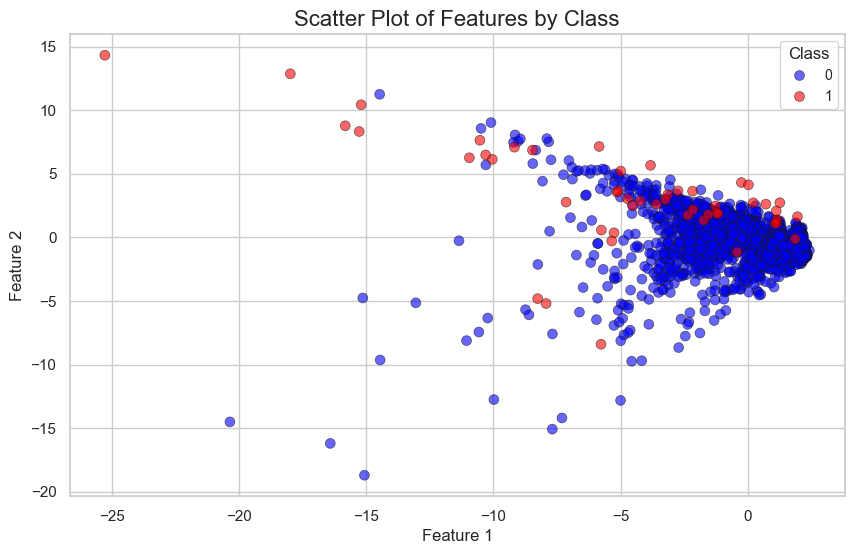

In [9]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

How would you describe the scatter plot?

SMOTE resampling

We are going to re-balance our data using the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class. 

- Use the 'prep_data' function on df to create features X and labels y. Print the shape of X and y. 
- Define the resampling method as 'SMOTE' of the regular kind, under the variable method.
- Use .fit_sample() on the original X and y to obtain newly resampled data.
- Plot the resampled data using the plot_data() function.

In [ ]:
# Run the prep_data function


In [ ]:
# shapes of X and y


In [ ]:

# Define the resampling method
method = SMOTE()

In [ ]:
# Create the resampled feature set
X_resampled, y_resampled = ..

In [ ]:
# Plot the resampled data



Q: what can you say about the minority class now? 

Print the value counts of our original labels, y. Be mindful that y is currently a Numpy array, so in order to use value counts, we'll assign y back as a pandas Series object.
Repeat the step and print the value counts on y_resampled.

In [ ]:
# value counts here


Fraud detection with ML

Split X and y into training and test data.
Fit your model LinearRegression to your training data.
Obtain the model predicted labels by running model.predict on X_test.
Obtain a classification comparing y_test with predicted, and use the given confusion matrix to check your results.

In [ ]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Statistical thresholds are often determined by looking at the mean values of observations. Let's start this exercise by checking whether feature means differ between fraud and non-fraud cases. Then, you'll use that information to create common sense thresholds. Finally, you'll check how well this performs in fraud detection.

Use groupby() to group df on Class and obtain the mean of the features.
Create the condition V1 smaller than -3, and V3 smaller than -5 as a condition to flag fraud cases. (this piece of code is in the end of the exercise.)
As a measure of performance, use the crosstab function from pandas to compare our flagged fraud cases to actual fraud cases.

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# Use groupby() to group df on Class and obtain the mean of the features


In [ ]:
# Create the condition V1 smaller than -3, and V3 smaller than -5 as a condition to flag fraud cases.


In [ ]:
 #use the crosstab function from pandas to compare our flagged fraud cases to actual fraud cases.
    

Q: How would you assess this rule?  (correct answer 4984, 16, 28, 22)

LogisticRegression

Split X and y into training and test data, keeping 30% of the data for testing.
Fit your LogisticRegression model to your training data. (solver='liblinear')
Obtain the model predicted labels by running model.predict on X_test.
Obtain a classification comparing y_test with predicted, and use the given confusion matrix to check your results.

In [ ]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = 
# Fit a logistic regression model to our data
model = ..

# Obtain model predictions


# Print the classifcation report and confusion matrix
# Generate and visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix with enhanced visualization.
    
    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_names (list): List of class names for labeling.
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Define class names for the confusion matrix (e.g., "Not Fraud" and "Fraud")
class_names = ["Not Fraud", "Fraud"]

print('Classification report:\n', classification_report(y_test, predicted))

plot_confusion_matrix(y_test, predicted, class_names)

Logistic regression with SMOTE

We combine the Logistic Regression model with a SMOTE resampling method using a pipeline that combines the resampling method with the model in one go. 

In [ ]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  

resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [ ]:
# pipeline here
pipeline = Pipeline(...)

Split X and y into training and test data, keeping 30% of the data for testing.
Fit the pipeline to your training data.
Obtain the results from the classification report and confusion matrix. 

In [ ]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = 


predicted = ..

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))

plot_confusion_matrix(y_test, predicted, class_names)

In [ ]:

# Obtain precision and recall 


Q: What were precision and recall? 

Random forest

We next use another set of credit card transaction data.  Also this data is heavily imbalanced. 

With this data, when betting that nothing is fraudulent, we would be right 95.89% of the time. To be effective, our fraud detections should beat this percentage. 

In [ ]:
df2 = pd.read_csv(cc2_file)
df2.head()

We do a simple random forest classification as a benchmark. 

Split your features X and labels y into a training and test set. Set aside a test set of 30%.
Assign the random forest classifier to model and keep random_state at 5. We need to set a random state here in order to be able to compare results across different models.


In [ ]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = ..

# Define the model as the random forest
model = RandomForestClassifier(...

# Fit the model to our training set


# Obtain predictions from the test data X_test
predicted = ..


Compute and print the accuracy score by comparing the actual labels y_test with our predicted labels predicted.
Then, compute the classification report and the confusion matrix.

In [ ]:
# accuracy score etc here


We adjust the random forest model to deal with highly imbalanced fraud data and set the class_weights option to 'balanced_subsample'.
random state=5, n_estimators=100. 

Define the model with balanced subsample. Fit your training model to your training set. Obtain the predicted values from the model. Compute the ROCAUC score, the classification report and the confusion matrix.  

In [ ]:
# Define the model with balanced subsample
model = RandomForestClassifier(... complete here)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values (and probabilities) from the model 


# Print the ROC score, classification report and confusion matrix


We will now define weights in the random forest classifier manually, to be able to off-set that imbalance slightly.

In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on. (correct piece of code in the end of the exercise)

Change the weight option to set the ratio to 1 to 12 for the non-fraud and fraud cases, and set the split criterion to 'entropy'.
Set the maximum depth to 10.
Set the minimal samples in leaf nodes to 10.
Set the number of trees to use in the model to 20.

Finally, print the ROC curve, classification report and confusion matrix.

In [ ]:
# Change the model options
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)


#Fit your training model to your training set
  
# Obtain the predicted values and probabilities from the model 

# ROC curve, classification report, confusion matrix


Q: What would you say about the results now?

We close this exercise by trying the Logistic regressor. 

Define a LogisticRegression model with class weights that are 1:15 for the fraud cases.
Fit the model to the training set, and obtain the model predictions.
Print the classification report and confusion matrix.

In [ ]:
# Define the Logistic Regression model with weights
model = LogisticRegression(.. complete here)

#Fit your training model to your training set
  
# Obtain the predicted values and probabilities from the model 

    
# ROC curve, classification report, confusion matrix

Q: how would you analyze the methods used?

In [ ]:
# pieces of code needed in the exercise. 

#df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [ ]:
# Change the model options
#model = RandomForestClassifier(bootstrap=True,
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)